# Eigenvalue Problem

Eigenvalue problem blabla

Unfortunately, we found tensorflow objects (such as tensorflow functions) hard to reuse. There is therefore much repetitive code in the code cells below. This notebook is organized such that each code cell have all the necessary code, except imports, to solve a particular problem. To better distinguish what problem a particular code cell solves, we have added headers and a small discussion before and after the code that explains the problem at hand. 

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## Euler's method

ODE RHS, two alternatives, benchmark which gives best result with Euler's method

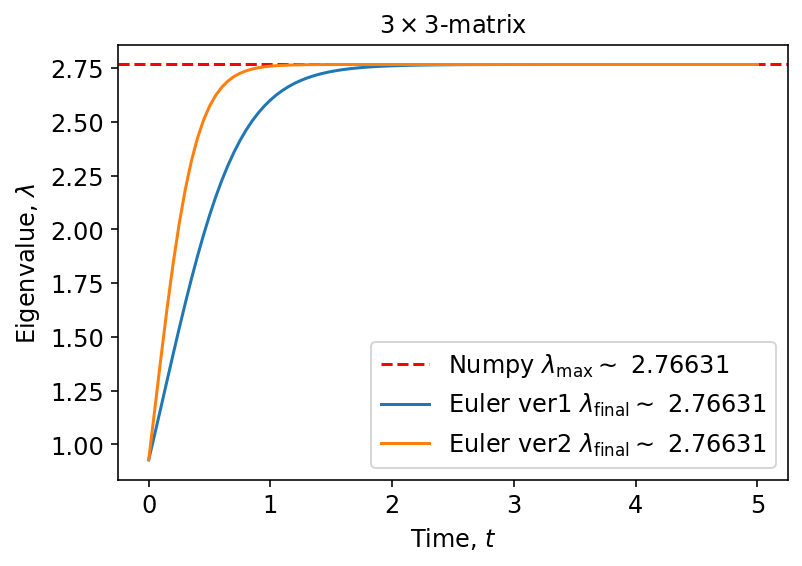

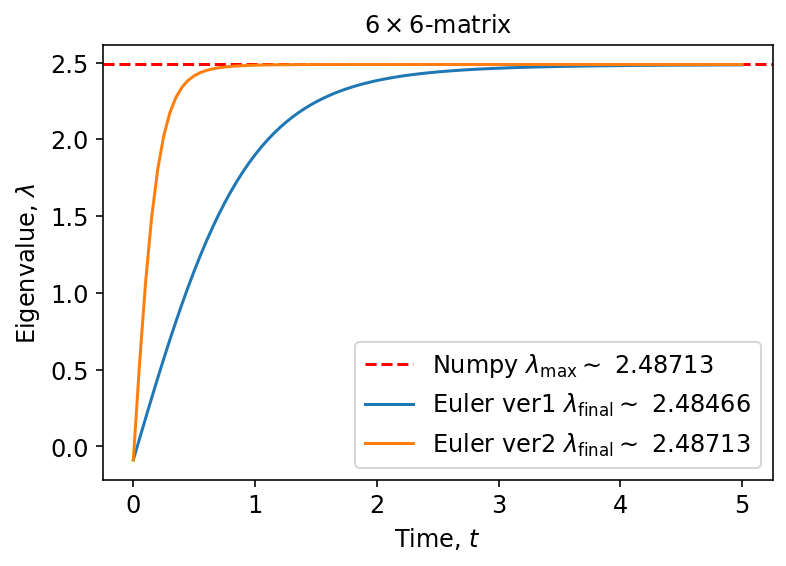

In [11]:
def ode_rhs_ver1(A, x):
    return (x.T@x) * A@x - (x.T@A@x) * x

def ode_rhs_ver2(A, x):
    return A@x - (x.T@x) * x

def euler_eig(A, x0, T, N, ver='ver1'):
    """
    Euler's method for computing eigenvalue
    """
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        if ver == 'ver1':
            x.append(x[-1] + dt * ode_rhs_ver1(A, x[-1]))
        elif ver == 'ver2': 
            x.append(x[-1] + dt * ode_rhs_ver2(A, x[-1]))
    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    return np.einsum("ij,ij->i", x @ A, x)

N = 101    # number of timesteps
T = 5     # final time

# Benchmark problem, 3x3 matrix
A = np.random.normal(0, 1, (3, 3))
A = (A.T + A) * 0.5    
x0 = np.random.rand(3)
x0 = x0 / np.linalg.norm(x0, ord=1)
t1 = np.linspace(0, T, N)
eig_euler_v1_1 = euler_eig(A, x0, T, N, ver='ver1')
eig_euler_v2_1 = euler_eig(A, x0, T, N, ver='ver2')
v1, w1 = np.linalg.eig(A)

# Benchmark problem, 6x6 matrix
A = np.random.normal(0, 1, (6, 6))
A = (A.T + A) * 0.5    
x0 = np.random.rand(6)
x0 = x0 / np.linalg.norm(x0, ord=1)
t2 = np.linspace(0, T, N)
eig_euler_v1_2 = euler_eig(A, x0, T, N, ver='ver1')
eig_euler_v2_2 = euler_eig(A, x0, T, N, ver='ver2')
v2, w2 = np.linalg.eig(A)


fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.axhline(np.max(v1), color='red', ls='--')
ax1.plot(t1, eig_euler_v1_1)
ax1.plot(t1, eig_euler_v2_1)
ax1.set_xlabel('Time, $t$')
ax1.set_ylabel('Eigenvalue, $\\lambda$')
ax1.set_title('$3 \\times 3$-matrix')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + str(round(np.max(v1), 5))
lgd_euler1 = "Euler ver1 $\\lambda_{\\mathrm{final}} \\sim$ " + str(round(eig_euler_v1_1[-1], 5))
lgd_euler2 = "Euler ver2 $\\lambda_{\\mathrm{final}} \\sim$ " + str(round(eig_euler_v2_1[-1], 5))
ax1.legend([lgd_numpy, lgd_euler1, lgd_euler2], loc='best')
fig1.savefig(fig_path("euler_benchmark_33.pdf"), bbox_inches='tight')

fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.axhline(np.max(v2), color='red', ls='--')
ax2.plot(t2, eig_euler_v1_2)
ax2.plot(t2, eig_euler_v2_2)
ax2.set_xlabel('Time, $t$')
ax2.set_ylabel('Eigenvalue, $\\lambda$')
ax2.set_title('$6 \\times 6$-matrix')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + str(round(np.max(v2), 5))
lgd_euler1 = "Euler ver1 $\\lambda_{\\mathrm{final}} \\sim$ " + str(round(eig_euler_v1_2[-1], 5))
lgd_euler2 = "Euler ver2 $\\lambda_{\\mathrm{final}} \\sim$ " + str(round(eig_euler_v2_2[-1], 5))
ax2.legend([lgd_numpy, lgd_euler1, lgd_euler2], loc='best')
fig2.savefig(fig_path("euler_benchmark_66.pdf"), bbox_inches='tight')

plt.show()

From the figures it seems like ODE RHS ver1 converges somewhat slower than ver2 in the 3x3 case. In the 6x6 case, however, ver1 often struggles to converge as good as ver2. Both these 'problems' probably arises because ver1 is more computationally demanding than ver2.

## FFNN Benchmark Problem

Step: 1, Loss: 1.277072134699062
Step: 100, Loss: 0.13565214997579453
Step: 200, Loss: 0.04199647585450174
Step: 300, Loss: 0.02320971415035938
Step: 400, Loss: 0.013092356825677515
Step: 500, Loss: 0.010640557392493376
Step: 600, Loss: 0.003952909408189469
Step: 700, Loss: 0.0019266407662336847
Step: 800, Loss: 0.002933022277414668
Step: 900, Loss: 0.005472781084249442
Step: 1000, Loss: 0.0003366347577388949
Step: 1100, Loss: 0.00016657266246487848
Step: 1200, Loss: 0.0005815261914622914
Step: 1300, Loss: 0.0028027506129634995
Step: 1400, Loss: 8.744178286420305e-05
Step: 1500, Loss: 9.128313022980171e-05
Step: 1600, Loss: 0.000615254294458216
Step: 1700, Loss: 0.00034588117090866583
Step: 1800, Loss: 6.694982150420078e-05
Step: 1900, Loss: 0.0002826787527766807
Step: 2000, Loss: 2.5482032466376834e-05

A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [1 0 0]
Eigvals Numpy: [-1.  8. -1.]
Max Eigval Numpy 8.0
Final Eigval Euler 7.999999884131663
Final Eigval FFNN 7.999998032651776


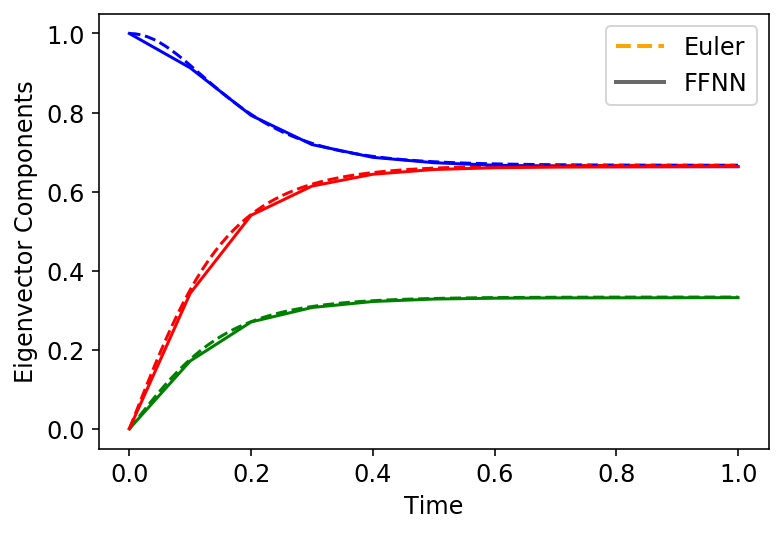

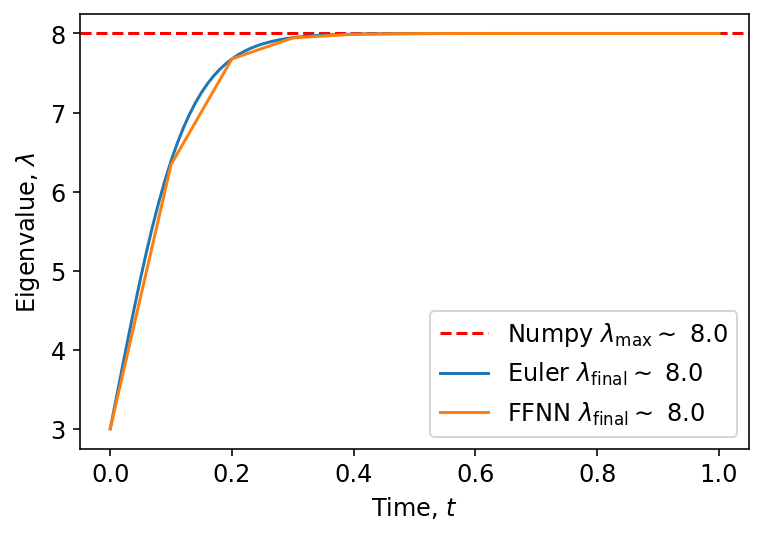

In [35]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Eigval Euler', eig_euler[-1])
print('Final Eigval FFNN', eig_nn.numpy()[-1])

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
custom_lines = [Line2D([0], [0], color='orange', ls='--', lw=2),
                Line2D([0], [0], color='dimgrey', lw=2)]
ax0.plot(t, x_euler[:, 0], color='b', ls='--')
ax0.plot(t, x_euler[:, 1], color='g', ls='--')
ax0.plot(t, x_euler[:, 2], color='r', ls='--')
ax0.plot(t_tf, g[:, 0], color='b')
ax0.plot(t_tf, g[:, 1], color='g')
ax0.plot(t_tf, g[:, 2], color='r')
ax0.set_ylabel('Eigenvector Components')
ax0.set_xlabel('Time')
ax0.legend(custom_lines, ['Euler', 'FFNN'])
fig0.savefig(fig_path("eigvec_comp_benchrun1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Eigenvalue, $\\lambda$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_benchrun1.pdf"), bbox_inches='tight')
plt.show()

## Benchmark problem

Step: 1, Loss: 1.4253581597021954
Step: 100, Loss: 0.21476604767755
Step: 200, Loss: 0.039775624865388534
Step: 300, Loss: 0.01585795719915563
Step: 400, Loss: 0.00975734490295043
Step: 500, Loss: 0.005421397775629549
Step: 600, Loss: 0.003581666273218884
Step: 700, Loss: 0.0022619801387375273
Step: 800, Loss: 0.0014662112555196025
Step: 900, Loss: 0.0005523088290164168
Step: 1000, Loss: 0.0002525744582020952
Step: 1100, Loss: 0.0012957323769615516
Step: 1200, Loss: 0.0003515574608535466
Step: 1300, Loss: 0.002101753722286153
Step: 1400, Loss: 0.0027004262994703818
Step: 1500, Loss: 0.0015220830552606828
Step: 1600, Loss: 0.00047903163081298354
Step: 1700, Loss: 0.0001020243892438309
Step: 1800, Loss: 3.319449977666575e-05
Step: 1900, Loss: 2.294216495952325e-05
Step: 2000, Loss: 1.6330124675615532e-05

A = [[-3. -2. -4.]
 [-2. -0. -2.]
 [-4. -2. -3.]]
x0 = [1 0 0]
Eigvals Numpy: [ 1. -8.  1.]
Max Eigval Numpy 1.0000000000000009
Final Eigval Euler 0.9999999410309908
Final Eigval FFNN 0

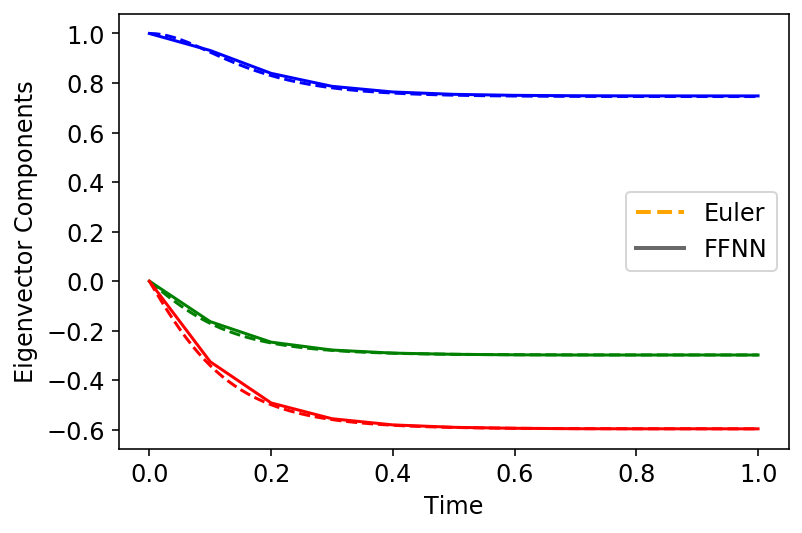

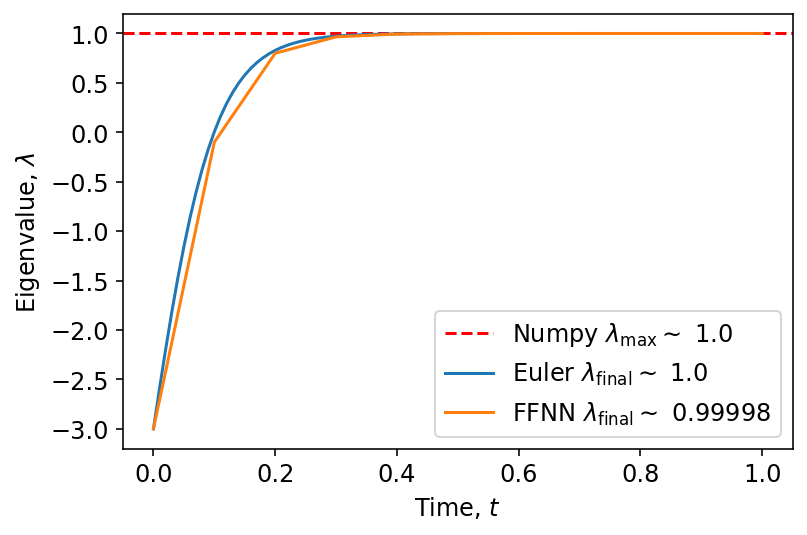

In [36]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        # x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
        #                       x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time
N = 101  # number of time points

# Benchmark problem, 3x3 matrix
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
A = -A
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Eigval Euler', eig_euler[-1])
print('Final Eigval FFNN', eig_nn.numpy()[-1])

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
custom_lines = [Line2D([0], [0], color='orange', ls='--', lw=2),
                Line2D([0], [0], color='dimgrey', lw=2)]
ax0.plot(t, x_euler[:, 0], color='b', ls='--')
ax0.plot(t, x_euler[:, 1], color='g', ls='--')
ax0.plot(t, x_euler[:, 2], color='r', ls='--')
ax0.plot(t_tf, g[:, 0], color='b')
ax0.plot(t_tf, g[:, 1], color='g')
ax0.plot(t_tf, g[:, 2], color='r')
ax0.set_ylabel('Eigenvector Components')
ax0.set_xlabel('Time')
ax0.legend(custom_lines, ['Euler', 'FFNN'])
fig0.savefig(fig_path("eigvec_comp_benchrun2.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Eigenvalue, $\\lambda$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_benchrun2.pdf"), bbox_inches='tight')
plt.show()

## 6x6

Step: 1, Loss: 1.3945865218491946
Step: 100, Loss: 0.0007279225967363037
Step: 200, Loss: 0.0006284139732119902
Step: 300, Loss: 0.00054103254381269
Step: 400, Loss: 0.00045108669380389667
Step: 500, Loss: 0.0003629665311132521
Step: 600, Loss: 0.00028581695419156044
Step: 700, Loss: 0.00023247953812181933
Step: 800, Loss: 0.00019877438469185165
Step: 900, Loss: 0.0001728953144141392
Step: 1000, Loss: 0.00014914115256009348
Step: 1100, Loss: 0.0001260046484666898
Step: 1200, Loss: 0.0001045494392697063
Step: 1300, Loss: 8.668440256243472e-05
Step: 1400, Loss: 7.258627843845206e-05
Step: 1500, Loss: 6.182077960997811e-05
Step: 1600, Loss: 5.3801137961530216e-05
Step: 1700, Loss: 4.782215184799131e-05
Step: 1800, Loss: 4.321288778421288e-05
Step: 1900, Loss: 3.944300936587104e-05
Step: 2000, Loss: 3.615440645401801e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1

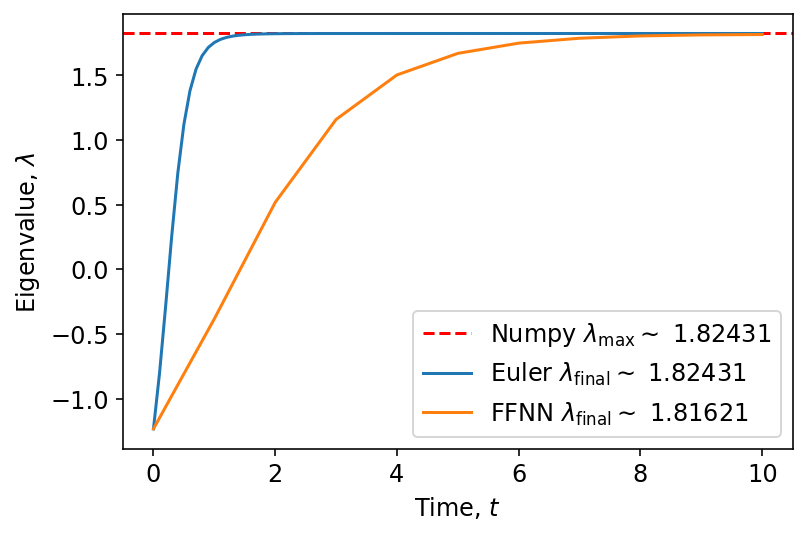

In [40]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        # x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
        #                       x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
n = 6    # Dimension
T = 10   # Final time
N = 101  # number of time points

# Benchmark problem
np.random.seed(42)
tf.random.set_seed(42)
A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Eigval Euler', eig_euler[-1])
print('Final Eigval FFNN', eig_nn.numpy()[-1])

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Eigenvalue, $\\lambda$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66a.pdf"), bbox_inches='tight')
plt.show()

Simple rhs

Step: 1, Loss: 0.5620474410540781
Step: 100, Loss: 0.0002465315416860827
Step: 200, Loss: 0.00017467095383713572
Step: 300, Loss: 0.00014189823766326483
Step: 400, Loss: 0.00010898118947305333
Step: 500, Loss: 7.515119103049334e-05
Step: 600, Loss: 5.4087582245488753e-05
Step: 700, Loss: 4.373511975639715e-05
Step: 800, Loss: 3.5796685195782506e-05
Step: 900, Loss: 2.9402047851296687e-05
Step: 1000, Loss: 2.4412603012556253e-05
Step: 1100, Loss: 2.0614718405388722e-05
Step: 1200, Loss: 1.7697228386487196e-05
Step: 1300, Loss: 1.537450564085324e-05
Step: 1400, Loss: 1.3451380064965269e-05
Step: 1500, Loss: 1.1808571434588874e-05
Step: 1600, Loss: 1.03715865861999e-05
Step: 1700, Loss: 9.095098369323055e-06
Step: 1800, Loss: 7.958230033825358e-06
Step: 1900, Loss: 6.955837382407061e-06
Step: 2000, Loss: 6.083913791549341e-06

A = [[-0.27071232 -0.02441395 -0.26005195  0.28373944  0.88360192 -0.01237785]
 [-0.02441395  0.78985181 -0.62996357 -0.12044088 -1.19613654 -0.37653447]
 [-0.26005

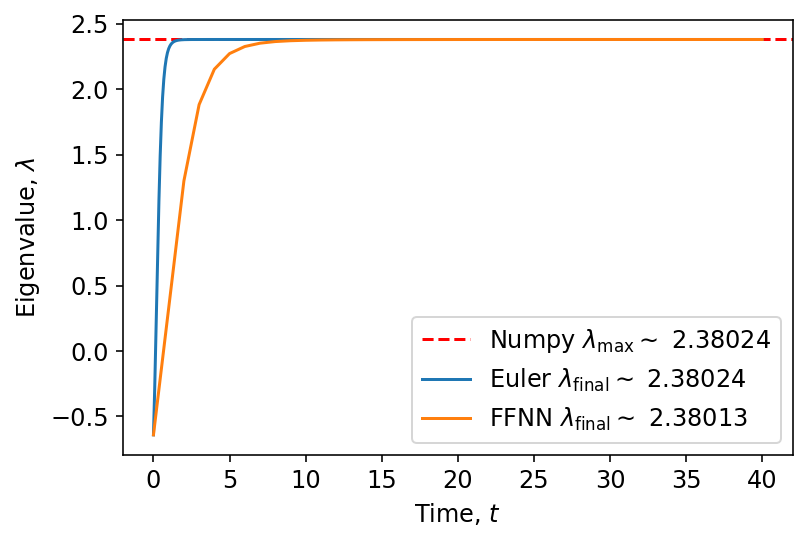

In [29]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    #return tf.einsum('jk,ik->ij', A, g) - tf.einsum('ij,ij,ik->ik', g, g, g)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        # x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
        #                       x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
n = 6    # Dimension
T = 40    # Final time
N = 1001  # number of time points

# Benchmark problem
np.random.seed(41)
tf.random.set_seed(41)
A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5 
#A = -A
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 41
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Eigval Euler', eig_euler[-1])
print('Final Eigval FFNN', eig_nn.numpy()[-1])

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Eigenvalue, $\\lambda$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $\\lambda_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66b.pdf"), bbox_inches='tight')
plt.show()